In [225]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

### Create MHC class 1 allele reference set

In [226]:
PATH_TO_REF_SET = 'data/hla_ref_set.class_i.csv'
ref_set_class_i = pd.read_csv(PATH_TO_REF_SET,header=None)

In [227]:
class_i_list = ref_set_class_i[0].tolist()
len(class_i_list)

27

# **Part 1.1**


## Part 1.1.1: Work

In [228]:
# TODO: Create and train a regression model for predicting pIC50 values for the data in MHCI_Binding_Data.csv
# NOTES: 1. You only need to make predictions for the 27 alleles in hla_ref_set.class_i.csv
#        2. There are several ways to approach this - please refer to the writeup for ideas/suggestions

### Data Exploration

In [229]:
# read in data
PATH_TO_MHC1_DATA = 'data/MHCI_Binding_Data.csv'
MHC1_df = pd.read_csv(PATH_TO_MHC1_DATA) 

# check whether there are other alleles present we don't care about
alleles_s = MHC1_df['HLA Allele'].unique()
len(alleles_s)

119

In [230]:
# filter out records which are not for the 27 listed alleles
MHC1_filtered_df = MHC1_df[MHC1_df['HLA Allele'].isin(class_i_list)]

print(len(MHC1_filtered_df['HLA Allele'].unique()))

MHC1_filtered_df

27


,species,HLA Allele,peptide_length,sequence,IC50 (nM concentration),pIC50
0,human,HLA-A*01:01,8,ASFCGSPY,51.400000,7.289037
1,human,HLA-A*01:01,8,LTDFGLSK,739.385479,6.131129
2,human,HLA-A*01:01,8,FTSFFYRY,1285.000000,5.891097
3,human,HLA-A*01:01,8,KSVFNSLY,1466.000000,5.833866
4,human,HLA-A*01:01,8,RDWAHNSL,1804.675523,5.743601
...,...,...,...,...,...,...
154069,human,HLA-B*58:01,15,GQQRSTLERTSKASL,46728.971960,4.330414
154070,human,HLA-B*58:01,15,QRSTLERTSKASLER,46728.971960,4.330414
154071,human,HLA-B*58:01,15,RALIKTLPRASYSSH,46728.971960,4.330414
154072,human,HLA-B*58:01,17,QFLKFSLPFPFLYKFLL,1973.420365,5.704780


In [231]:
# check how much data we have per allele
MHC1_filtered_df['HLA Allele'].value_counts()

HLA-A*02:01    12160
HLA-A*03:01     7358
HLA-A*11:01     6399
HLA-A*02:03     6303
HLA-A*31:01     5713
HLA-A*02:06     5628
HLA-A*68:02     5545
HLA-A*01:01     4792
HLA-B*07:02     4642
HLA-A*26:01     4535
HLA-B*15:01     4448
HLA-A*68:01     3795
HLA-A*33:01     3597
HLA-B*08:01     3538
HLA-B*40:01     3443
HLA-B*58:01     3350
HLA-A*24:02     3280
HLA-B*35:01     3211
HLA-A*30:01     2925
HLA-B*57:01     2903
HLA-B*51:01     2901
HLA-A*23:01     2641
HLA-B*44:02     2318
HLA-A*30:02     2057
HLA-B*53:01     1720
HLA-B*44:03     1404
HLA-A*32:01     1136
Name: HLA Allele, dtype: int64

In [232]:
# check how much data we have per length
MHC1_filtered_df['peptide_length'].value_counts().sort_index()

8      1854
9     83083
10    24300
11     1668
12      140
13      268
14      168
15      206
17       27
18       27
30        1
Name: peptide_length, dtype: int64

### Generate standard sequence lengths
Most of the data is concentrated in the 9 and 10 length range, so it makes sense to build a model based on those lengths. 

- All sequences longer than 8 can be truncated to a length of 9. 
- Sequences of length 8 have a non-coding letter appended.
- Sequences of length 10 lose only their last coding letter.

In [233]:
def get_n_length_seq(seq,n):
    '''
    Returns a string of the first n characters of the given sequence.
    
    If given sequence has less than n characters, appends J until
    the desired length has been reached, then returns that string.

    Note that J does not code for a natural amino acid.
    '''
    seq_length = len(seq)
    if seq_length < n:
        # append dummy variable J to make it length n
        addition = (n - seq_length) * 'J'
        result = seq + addition
    else:
        # retain the first 9 characters of sequence
        result = seq[:n]
    return result


In [234]:
# test
print(get_n_length_seq('ABCDEFG',10))
print(get_n_length_seq('ABCDEFG',9))

ABCDEFGJJJ
ABCDEFGJJ


In [235]:
# add a column with the 9-length sequence for every record
MHC1_filtered_df.loc[:, ('seq_standard')]=MHC1_filtered_df.apply(lambda x: get_n_length_seq(x['sequence'],9),axis=1)

MHC1_filtered_df

/opt/anaconda3/envs/CMU-02718-HW5/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/anaconda3/envs/CMU-02718-HW5/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


,species,HLA Allele,peptide_length,sequence,IC50 (nM concentration),pIC50,seq_standard
0,human,HLA-A*01:01,8,ASFCGSPY,51.400000,7.289037,ASFCGSPYJ
1,human,HLA-A*01:01,8,LTDFGLSK,739.385479,6.131129,LTDFGLSKJ
2,human,HLA-A*01:01,8,FTSFFYRY,1285.000000,5.891097,FTSFFYRYJ
3,human,HLA-A*01:01,8,KSVFNSLY,1466.000000,5.833866,KSVFNSLYJ
4,human,HLA-A*01:01,8,RDWAHNSL,1804.675523,5.743601,RDWAHNSLJ
...,...,...,...,...,...,...,...
154069,human,HLA-B*58:01,15,GQQRSTLERTSKASL,46728.971960,4.330414,GQQRSTLER
154070,human,HLA-B*58:01,15,QRSTLERTSKASLER,46728.971960,4.330414,QRSTLERTS
154071,human,HLA-B*58:01,15,RALIKTLPRASYSSH,46728.971960,4.330414,RALIKTLPR
154072,human,HLA-B*58:01,17,QFLKFSLPFPFLYKFLL,1973.420365,5.704780,QFLKFSLPF


###  Encode the features

In [236]:
# split 9 sequence into one column per letter
# encode letter as ASCII number
test = MHC1_filtered_df.head(2)
col_list = ['s1','s2','s3','s4','s5','s6','s7','s8','s9']
test[col_list]=test['seq_standard'].apply(lambda x: pd.Series([ord(char) for char in str(x)]))
test


/opt/anaconda3/envs/CMU-02718-HW5/lib/python3.8/site-packages/pandas/core/frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,species,HLA Allele,peptide_length,sequence,IC50 (nM concentration),pIC50,seq_standard,s1,s2,s3,s4,s5,s6,s7,s8,s9
0,human,HLA-A*01:01,8,ASFCGSPY,51.400000,7.289037,ASFCGSPYJ,65,83,70,67,71,83,80,89,74
1,human,HLA-A*01:01,8,LTDFGLSK,739.385479,6.131129,LTDFGLSKJ,76,84,68,70,71,76,83,75,74


In [237]:
# split 9 sequence into one column per letter
# encode letter as ASCII number

col_list = ['s1','s2','s3','s4','s5','s6','s7','s8','s9']
MHC1_filtered_df[col_list]=MHC1_filtered_df.seq_standard.apply(lambda x: pd.Series([ord(char) for char in str(x)]))

MHC1_filtered_df

/opt/anaconda3/envs/CMU-02718-HW5/lib/python3.8/site-packages/pandas/core/frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,species,HLA Allele,peptide_length,sequence,IC50 (nM concentration),pIC50,seq_standard,s1,s2,s3,s4,s5,s6,s7,s8,s9
0,human,HLA-A*01:01,8,ASFCGSPY,51.400000,7.289037,ASFCGSPYJ,65,83,70,67,71,83,80,89,74
1,human,HLA-A*01:01,8,LTDFGLSK,739.385479,6.131129,LTDFGLSKJ,76,84,68,70,71,76,83,75,74
2,human,HLA-A*01:01,8,FTSFFYRY,1285.000000,5.891097,FTSFFYRYJ,70,84,83,70,70,89,82,89,74
3,human,HLA-A*01:01,8,KSVFNSLY,1466.000000,5.833866,KSVFNSLYJ,75,83,86,70,78,83,76,89,74
4,human,HLA-A*01:01,8,RDWAHNSL,1804.675523,5.743601,RDWAHNSLJ,82,68,87,65,72,78,83,76,74
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154069,human,HLA-B*58:01,15,GQQRSTLERTSKASL,46728.971960,4.330414,GQQRSTLER,71,81,81,82,83,84,76,69,82
154070,human,HLA-B*58:01,15,QRSTLERTSKASLER,46728.971960,4.330414,QRSTLERTS,81,82,83,84,76,69,82,84,83
154071,human,HLA-B*58:01,15,RALIKTLPRASYSSH,46728.971960,4.330414,RALIKTLPR,82,65,76,73,75,84,76,80,82
154072,human,HLA-B*58:01,17,QFLKFSLPFPFLYKFLL,1973.420365,5.704780,QFLKFSLPF,81,70,76,75,70,83,76,80,70


### Data Visualization
To help see what type of regression model best fits the data.

In [238]:
from sklearn.decomposition import PCA

def get_allele_data(df,allele):
    '''
    Returns a DataFrame with data only for the given allele.
    '''
    return df[df['HLA Allele'] == allele]


def split_feature_and_target(df):
    '''
    Returns a tuple of (X,y), where X is a DataFrame 
    of the features of the dataset and y is a Series
    of the target.
    
    Features consist only of the sequence columns 
    with individual encoded letters.
    
    Target is the pIC50 column.
    '''
    drop_list = ['species','HLA Allele','peptide_length','sequence','seq_standard','IC50 (nM concentration)', 'pIC50']
    X = df.drop(drop_list,axis=1)
    y = df['pIC50']
    return (X,y)


def visualize_data(df, allele,a1,a2):
#     print(allele,a1,a2)
    X,y = split_feature_and_target(get_allele_data(df,allele))
    rows = X.shape[0]

    if rows > 0:
        # use PCA to visualize data
        pca = PCA(n_components=2)
        pca.fit(X)
        X_pca = pca.transform(X)
        axs[a1,a2].scatter(X_pca[:,0],X_pca[:,1])
    

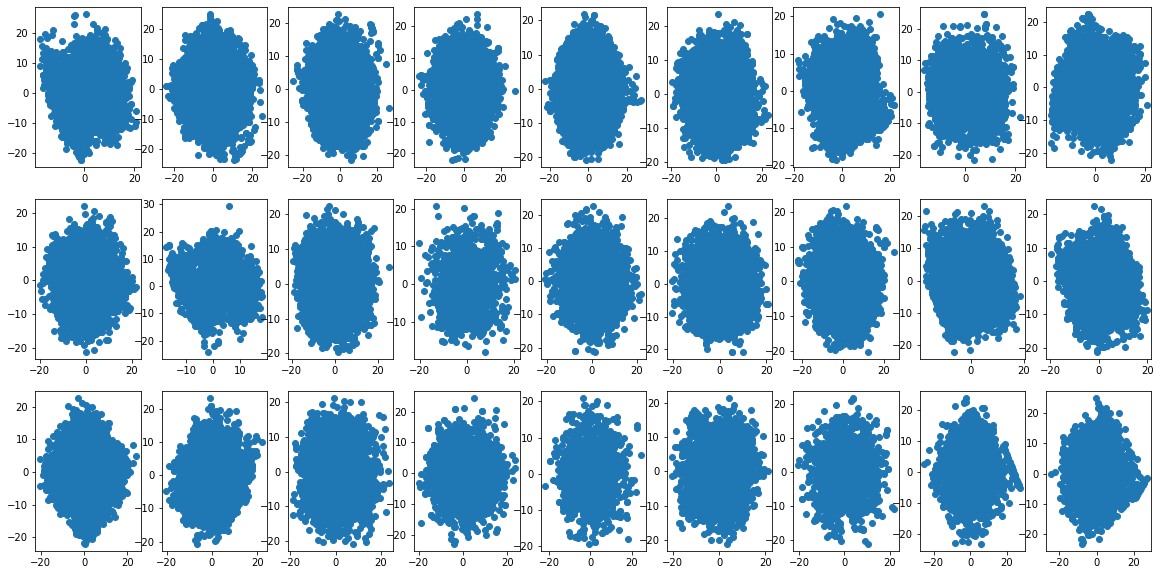

In [239]:
fig, axs = plt.subplots(3,9,figsize=(20,10))

a1 = 0
a2 = 0
for allele in class_i_list:
    if a2 > 8:
        a1 += 1
        a2 = 0
        
    visualize_data(MHC1_filtered_df,allele,a1,a2)
    
    a2 += 1


### Train Regression Models
We'll use a linear regression model for each allele. There doesn't appear to be a nonlinear relationship within the data.

Additionally, I'll create a separate model for each allele. There may not be a relationship between the alleles themselves (at least, not the same sort of relationship as the features may have within a single allele). By creating separate models, we prevent any relationship between alleles from manipulating the fit.

In [240]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from numpy import mean
from numpy import std

def train_regresson_model(df,allele):
    '''
    Fits a regression model to the data for a 
    given allele and returns the model.
    '''
    df_allele = get_allele_data(df,allele)
    X,y = split_feature_and_target(df_allele)
    
    rows = X.shape[0]
    if rows > 0:
    
        model = LinearRegression()
        return model.fit(X,y)
    else:
        return None
    


def score_regression_model(df,allele):
    '''
    Trains a linear regression model on data for
    a given allele, using 5-fold cross validation.
    
    Returns the mean and standard deviation of the
    cross validation scores as a tuple (mean,std_dev).
    '''
    df_allele = get_allele_data(df,allele)
    X,y = split_feature_and_target(df_allele)
    
    rows = X.shape[0]
    if rows > 0:
    
        # setup crossfold validation
        cv = KFold(n_splits=5, random_state=1, shuffle=True)   

        # learn model
        model = LinearRegression()
        scores = cross_val_score(model, X, y, scoring='r2', cv=cv)
    
        return (mean(scores),std(scores))
    else:
        return (0.0,0.0)


In [241]:
#?? am I supposed to then run the entire model again using .fit(X,y) so that I can use it to predict in 1.3
#?? are the R2 values I'm getting good or bad? not sure what the range should be

In [242]:
# for each of the 27 alleles, learn a separate regression model

results = []
for allele in class_i_list:
    m,s = score_regression_model(MHC1_filtered_df,allele)
    result = [allele,round(s,5),round(m,5)] # std_dev before mean
    results.append(result)
    

In [243]:
# TODO: Create a table where each row corresponds to one of the MHC I binding affinity models above, and
#       the final column is the Coefficient of determination (ie. R^2) of the model using 5-fold cross validation.  

In [244]:
mhc1_results_df = pd.DataFrame(data=results,columns = ['Allele','Std_dev','R_2'])
print(mhc1_results_df.shape)
mhc1_results_df


(27, 3)


,Allele,Std_dev,R_2
0,HLA-A*01:01,0.01841,0.14294
1,HLA-A*02:01,0.00248,0.01546
2,HLA-A*02:03,0.00584,0.01276
3,HLA-A*02:06,0.00347,0.01386
4,HLA-A*03:01,0.00769,0.00918
5,HLA-A*11:01,0.00703,0.02622
6,HLA-A*23:01,0.01729,0.12681
7,HLA-A*24:02,0.02160,0.13617
8,HLA-A*26:01,0.02375,0.05641
9,HLA-A*30:01,0.02190,0.04192


## Part 1.1.1: Answer

Briefly describe your approach for creating the regression model: **YOUR EXPLANATION HERE**

**Include the table as the output of the cell above or embed it as an image in this cell**

## Part 1.1.2: Work

In [245]:
# TODO: Create and train a regression model for predicting pIC50 values for the data in MHCII_Binding_Data.csv
# NOTES: 1. You only need to make predictions for the 27 alleles in hla_ref_set.class_i.csv
#        2. There are several ways to approach this - please refer to the writeup for ideas/suggestions

### Create MHC class 2 allele reference set

In [246]:
PATH_TO_REF_SET = 'data/hla_ref_set.class_ii.csv'
ref_set_class_ii = pd.read_csv(PATH_TO_REF_SET,header=None)

In [247]:
class_ii_list = ref_set_class_ii[0].tolist()
len(class_ii_list)

27

### Data Exploration

In [248]:
# read in data
PATH_TO_MHC2_DATA = 'data/MHCII_Binding_Data.csv'
MHC2_df = pd.read_csv(PATH_TO_MHC2_DATA) 

# rename allele column to match MHC1 data
MHC2_renamed_df = MHC2_df.rename(columns={"mhc": "HLA Allele"})
MHC2_renamed_df

# check whether there are other alleles present we don't care about
alleles_s = MHC2_renamed_df['HLA Allele'].unique()
len(alleles_s)

26

In [249]:
# filter out records which are not for the 27 listed alleles
MHC2_filtered_df = MHC2_renamed_df[MHC2_renamed_df['HLA Allele'].isin(class_ii_list)]

print(len(MHC2_filtered_df['HLA Allele'].unique()))

MHC2_filtered_df

24


,species,HLA Allele,peptide_length,sequence,IC50 (nM concentration),pIC50
1337,human,HLA-DPA1*0103/DPB1*0201,15,EKKYFAATCFEPLAA,1.000000,9.000000
1338,human,HLA-DPA1*0103/DPB1*0201,15,EKKYLAATQFEPLAA,1.186663,8.925673
1339,human,HLA-DPA1*0103/DPB1*0201,15,FTVFEAAFNNAIKAG,1176.286073,5.929487
1340,human,HLA-DPA1*0103/DPB1*0201,15,ATTEEQKLIEDINAS,7907.221929,5.101976
1341,human,HLA-DPA1*0103/DPB1*0201,15,HPQDGDALTLRTATN,16722.408030,4.776701
...,...,...,...,...,...,...
44909,human,HLA-DRB5*0101,13,AQTTANPSCPEGT,51388.587790,4.289133
44910,human,HLA-DRB5*0101,15,HCNEMSWIQSIPFVH,827.589696,6.082185
44911,human,HLA-DRB5*0101,15,PADKYRTFVATFGAA,12.679630,7.896893
44912,human,HLA-DRB5*0101,15,SSTVKLRQNEFGPAR,1595.840659,5.797010


In [250]:
# check how much data we have per allele
MHC2_filtered_df['HLA Allele'].value_counts()

HLA-DRB1*0101              6427
HLA-DRB1*1101              1794
HLA-DRB1*0401              1769
HLA-DRB5*0101              1769
HLA-DRB1*1501              1769
HLA-DRB1*0701              1745
HLA-DQA1*0101/DQB1*0501    1739
HLA-DQA1*0301/DQB1*0302    1719
HLA-DRB1*0301              1715
HLA-DQA1*0401/DQB1*0402    1701
HLA-DQA1*0501/DQB1*0301    1689
HLA-DQA1*0501/DQB1*0201    1658
HLA-DQA1*0102/DQB1*0602    1629
HLA-DRB1*0405              1582
HLA-DRB1*1302              1580
HLA-DRB4*0101              1521
HLA-DRB1*0802              1520
HLA-DRB1*0901              1520
HLA-DRB3*0101              1501
HLA-DPA1*0201/DPB1*0501    1410
HLA-DPA1*0301/DPB1*0402    1407
HLA-DPA1*0103/DPB1*0201    1404
HLA-DPA1*0201/DPB1*0101    1399
HLA-DPA1*0103/DPB1*0401    1033
Name: HLA Allele, dtype: int64

In [251]:
# check how much data we have per length
MHC2_filtered_df['peptide_length'].value_counts().sort_index()

9        17
10       89
11      116
12       78
13      425
14      352
15    40106
16     1092
17      348
18      106
19      121
20      120
21       18
23        4
37        8
Name: peptide_length, dtype: int64

In [252]:
# TODO: Create a table where each row corresponds to one of the MHC II binding affinity models above, and
#       the final column is the Coefficient of determination (ie. R^2) of the model using 5-fold cross validation.  

### Generate standard sequence lengths
Most of the data is concentrated in the 15 length range, so it makes sense to build a model based on that length. 

- All sequences longer than 14 can be truncated to a length of 15. 
- Sequences of length < 15 have a non-coding letter appended.
- Sequences of length 16 lose only their last coding letter.

In [253]:
# add a column with the 9-length sequence for every record
MHC2_filtered_df.loc[:, ('seq_standard')]=MHC2_filtered_df.apply(lambda x: get_n_length_seq(x['sequence'],15),axis=1)

MHC2_filtered_df

/opt/anaconda3/envs/CMU-02718-HW5/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/anaconda3/envs/CMU-02718-HW5/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


,species,HLA Allele,peptide_length,sequence,IC50 (nM concentration),pIC50,seq_standard
1337,human,HLA-DPA1*0103/DPB1*0201,15,EKKYFAATCFEPLAA,1.000000,9.000000,EKKYFAATCFEPLAA
1338,human,HLA-DPA1*0103/DPB1*0201,15,EKKYLAATQFEPLAA,1.186663,8.925673,EKKYLAATQFEPLAA
1339,human,HLA-DPA1*0103/DPB1*0201,15,FTVFEAAFNNAIKAG,1176.286073,5.929487,FTVFEAAFNNAIKAG
1340,human,HLA-DPA1*0103/DPB1*0201,15,ATTEEQKLIEDINAS,7907.221929,5.101976,ATTEEQKLIEDINAS
1341,human,HLA-DPA1*0103/DPB1*0201,15,HPQDGDALTLRTATN,16722.408030,4.776701,HPQDGDALTLRTATN
...,...,...,...,...,...,...,...
44909,human,HLA-DRB5*0101,13,AQTTANPSCPEGT,51388.587790,4.289133,AQTTANPSCPEGTJJ
44910,human,HLA-DRB5*0101,15,HCNEMSWIQSIPFVH,827.589696,6.082185,HCNEMSWIQSIPFVH
44911,human,HLA-DRB5*0101,15,PADKYRTFVATFGAA,12.679630,7.896893,PADKYRTFVATFGAA
44912,human,HLA-DRB5*0101,15,SSTVKLRQNEFGPAR,1595.840659,5.797010,SSTVKLRQNEFGPAR


###  Encode the features

In [254]:
# split 15 sequence into one column per letter
# encode letter as ASCII number

col_list = ['s1','s2','s3','s4','s5','s6','s7','s8','s9','s10','s11','s12','s13','s14','s15']
MHC2_filtered_df[col_list]=MHC2_filtered_df.seq_standard.apply(lambda x: pd.Series([ord(char) for char in str(x)]))

MHC2_filtered_df

/opt/anaconda3/envs/CMU-02718-HW5/lib/python3.8/site-packages/pandas/core/frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,species,HLA Allele,peptide_length,sequence,IC50 (nM concentration),pIC50,seq_standard,s1,s2,s3,...,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15
1337,human,HLA-DPA1*0103/DPB1*0201,15,EKKYFAATCFEPLAA,1.000000,9.000000,EKKYFAATCFEPLAA,69,75,75,...,65,65,84,67,70,69,80,76,65,65
1338,human,HLA-DPA1*0103/DPB1*0201,15,EKKYLAATQFEPLAA,1.186663,8.925673,EKKYLAATQFEPLAA,69,75,75,...,65,65,84,81,70,69,80,76,65,65
1339,human,HLA-DPA1*0103/DPB1*0201,15,FTVFEAAFNNAIKAG,1176.286073,5.929487,FTVFEAAFNNAIKAG,70,84,86,...,65,65,70,78,78,65,73,75,65,71
1340,human,HLA-DPA1*0103/DPB1*0201,15,ATTEEQKLIEDINAS,7907.221929,5.101976,ATTEEQKLIEDINAS,65,84,84,...,81,75,76,73,69,68,73,78,65,83
1341,human,HLA-DPA1*0103/DPB1*0201,15,HPQDGDALTLRTATN,16722.408030,4.776701,HPQDGDALTLRTATN,72,80,81,...,68,65,76,84,76,82,84,65,84,78
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44909,human,HLA-DRB5*0101,13,AQTTANPSCPEGT,51388.587790,4.289133,AQTTANPSCPEGTJJ,65,81,84,...,78,80,83,67,80,69,71,84,74,74
44910,human,HLA-DRB5*0101,15,HCNEMSWIQSIPFVH,827.589696,6.082185,HCNEMSWIQSIPFVH,72,67,78,...,83,87,73,81,83,73,80,70,86,72
44911,human,HLA-DRB5*0101,15,PADKYRTFVATFGAA,12.679630,7.896893,PADKYRTFVATFGAA,80,65,68,...,82,84,70,86,65,84,70,71,65,65
44912,human,HLA-DRB5*0101,15,SSTVKLRQNEFGPAR,1595.840659,5.797010,SSTVKLRQNEFGPAR,83,83,84,...,76,82,81,78,69,70,71,80,65,82


### Data Visualization
To help see what type of regression model best fits the data.

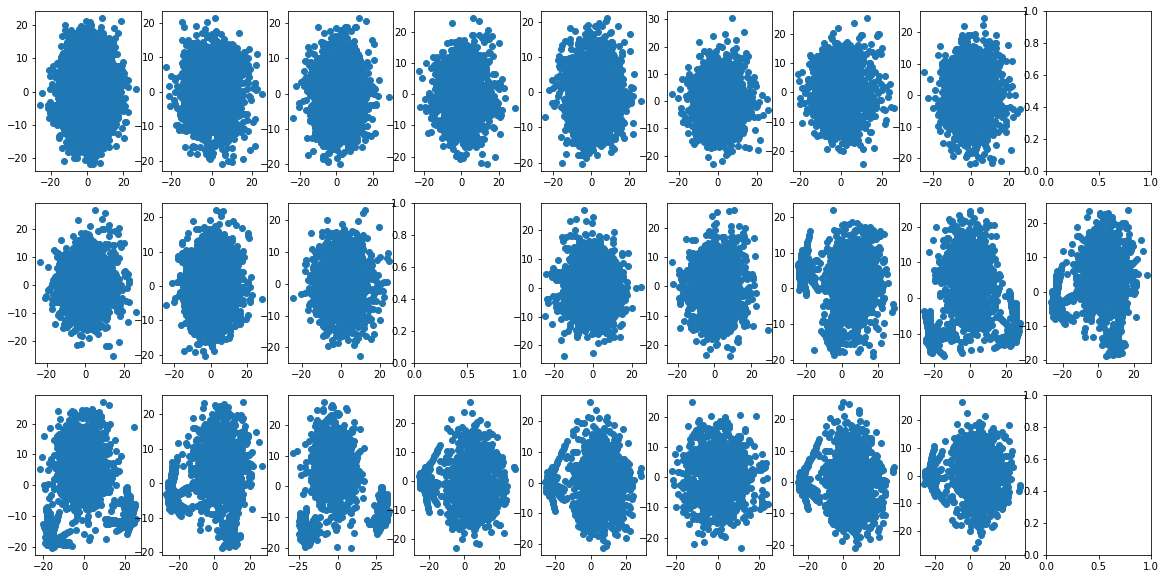

In [255]:
fig, axs = plt.subplots(3,9,figsize=(20,10))

a1 = 0
a2 = 0

for allele in class_ii_list:
    
    if a2 > 8:
        a1 += 1
        a2 = 0
        
    visualize_data(MHC2_filtered_df,allele,a1,a2)
    
    a2 += 1


### Train Regression Models
We'll use a linear regression model for each allele. There doesn't appear to be a nonlinear relationship within the data.

Additionally, I'll create a separate model for each allele. There may not be a relationship between the alleles themselves (at least, not the same sort of relationship as the features may have within a single allele). By creating separate models, we prevent any relationship between alleles from manipulating the fit.

In [256]:
# for each of the 27 alleles, learn a separate regression model

results = []
for allele in class_ii_list:
    m,s = score_regression_model(MHC2_filtered_df,allele)
    result = [allele,round(s,5),round(m,5)] # std_dev before mean
    results.append(result)
    

In [257]:
mhc2_results_df = pd.DataFrame(data=results,columns = ['Allele','Std_dev','R_2'])
print(mhc2_results_df.shape)
mhc2_results_df


(27, 3)


,Allele,Std_dev,R_2
0,HLA-DRB1*0101,0.00480,0.01837
1,HLA-DRB1*0301,0.01892,0.02012
2,HLA-DRB1*0401,0.02594,0.00578
3,HLA-DRB1*0405,0.03876,0.02194
4,HLA-DRB1*0701,0.01784,0.04341
5,HLA-DRB1*0802,0.01448,0.00948
6,HLA-DRB1*0901,0.01012,0.00673
7,HLA-DRB1*1101,0.02564,0.02873
8,HLA-DRB1*1201,0.00000,0.00000
9,HLA-DRB1*1302,0.01447,0.00637


## Part 1.1.2: Answer

Briefly describe your approach for creating the regression model: **YOUR EXPLANATION HERE**

**Include the table as the output of the cell above or embed it as an image in this cell**

# Part 1.2

## Part 1.2: Work 

### Read spike sequence

In [258]:
# TIP: The .fasta files usually start with some header describing the meta information. 
#      The code below skips the header and joins the lines of the sequence to obtain
#      the full protein sequence

In [259]:
def get_spike_sequence(filename):
    '''
    Reads file in FASTA format and returns 
    the sequence as a numpy character array.
    '''
    
    # from Bio import SeqIO
    # with open(PATH_TO_FASTA, "r") as handle:
    #     for record in SeqIO.parse(handle, "fasta"):
    #         seq = record.seq
    #         seq_id = record.id
  
    with open(PATH_TO_FASTA) as f:
        sequence = ''.join(f.read().split('\n')[1:])   
        return np.array([char for char in sequence])

In [260]:
# build character array of full sequence
PATH_TO_FASTA = 'data/SARS-CoV2-Spike.fasta' 
spike_sequence = get_spike_sequence(PATH_TO_FASTA)
len(spike_sequence)

1273

### Split spike sequence into k-mers
My method is to use a generator to return k-mers one at a time, rather than need to store all k-mers in a data structure. The generator terminates when there all k-mers have been generated.

In [261]:
# TODO: Split protein sequence from SARS-CoV2-Spike.fasta into 
# overlapping k-mers for your choice of k 

In [262]:
def split_spike_sequence(seq,k):
    '''
    Returns a generator for k-mers.
    
    Each iteration of the generator returns a tuple containing
    the next k-mer of the sequence in following form:
    (start index, end index, k-mer)
    '''
    
    start = 0
    end = start + (k-1)
    last_position = len(seq) - 1

    while end <= last_position:
        
        yield (start,end,seq[start:end+1])
        
        # get next sequence
        start = start + 1
        end = start + (k-1)


In [263]:
# test
print(spike_sequence[:12])
print()
for each in split_spike_sequence(spike_sequence[:12],9):
    print(each)


['M' 'F' 'V' 'F' 'L' 'V' 'L' 'L' 'P' 'L' 'V' 'S']

(0, 8, array(['M', 'F', 'V', 'F', 'L', 'V', 'L', 'L', 'P'], dtype='<U1'))
(1, 9, array(['F', 'V', 'F', 'L', 'V', 'L', 'L', 'P', 'L'], dtype='<U1'))
(2, 10, array(['V', 'F', 'L', 'V', 'L', 'L', 'P', 'L', 'V'], dtype='<U1'))
(3, 11, array(['F', 'L', 'V', 'L', 'L', 'P', 'L', 'V', 'S'], dtype='<U1'))


## Part 1.2: Answer

What was the value of k you used to create the overlapping k-mers? **For MHC I data, I used a value of k=9. For MHC II data, I used a value of k=15.**

# Part 1.3

## Part 1.3: Work

In [264]:
# TODO: 1. Apply the models you created in part 1.1 to the k-mers you created in part 1.2.  
#       2. Store the returned labeled (MHC, peptide) pairs where the label is the predicted pIC50 value
#       3. Determine the min, max, mean, median, and std. dev of the predicted pIC50 values for each MHC class

### Apply MHC 1 Models to k-mers
Generate a set of labeled (MHC,peptide) pairs, where the label is the predicted pIC50 value.

In [265]:
def encode_seq(sequence):
    '''
    Converts numpy character array to numpy integer array
    where each character is the ASCII encoded value.
    '''
    encoder = lambda t: ord(t)
    vfunc = np.vectorize(encoder)
    return vfunc(sequence)    
    
    
def split_into_features(seq):
    '''
    Takes an encoded sequence and returns a 
    DataFrame with each element as its own
    column.
    '''
    return pd.DataFrame(seq).T


def get_predictions(model,allele,seq,k,results):
    '''
    Using given regression model, calculates
    pIC50 for each k-mer in the given protein 
    sequence and appends the result to results
    as a tuple (allele,peptide,start,end,pIC50).
    '''
    
    # executes once for each k-mer in the sequence
    for start,end,seq in split_spike_sequence(seq,k):

        # convert to encoded form
        encoded = encode_seq(seq)

        # split into features
        features = split_into_features(encoded)

        # predict pIC50 using given model
        pIC50 = model.predict(features)[0]

        # get peptide for results
        peptide = ''.join([char for char in seq])

        # save in results
        results.append((allele,peptide,start,end,pIC50)) 
    

def predict_pIC50_values(allele_list, df, seq, k):
    '''
    For each allele in the allele list, trains a
    Linear Regression model using the given data
    then uses that model to predict pIC50 for each
    k-mer in the given protein sequence.
    
    Returns a list of all results.
    '''
    
    results = []

    for allele in allele_list:
    
        # train model for this allele
        model = train_regresson_model(df,allele)
        
        # use model as long as it is not None
        if model:

            # use model to predict pIC50 for each k-mer in the sequence
            get_predictions(model,allele,seq,k,results)
        
    return results

In [266]:
# test to ensure encoding is working

print(spike_sequence[:4])
print(encode_seq(spike_sequence[:4]))
for each in encode_seq(spike_sequence[:4]):
    print(chr(each))

['M' 'F' 'V' 'F']
[77 70 86 70]
M
F
V
F


In [267]:
# test for 2 k-mers to ensure the correct number of results are found

print(spike_sequence[:10])
results = predict_pIC50_values(class_i_list,MHC1_filtered_df,spike_sequence[:10],9)
print(len(results))
results[:2]

['M' 'F' 'V' 'F' 'L' 'V' 'L' 'L' 'P' 'L']
54


[('HLA-A*01:01', 'MFVFLVLLP', 0, 8, 4.737117169033365),
 ('HLA-A*01:01', 'FVFLVLLPL', 1, 9, 5.278242131584745)]

In [268]:
%%time

# There are 1265 9-mers over sequence of 1273 letters
expected = 27 * 1265
results_mhc1 = predict_pIC50_values(class_i_list,MHC1_filtered_df,spike_sequence,9)
actual = len(results_mhc1)
assert expected == actual

CPU times: user 59.2 s, sys: 321 ms, total: 59.5 s
Wall time: 43.8 s


### Apply MHC 2 Models to k-mers
Generate a set of labeled (MHC,peptide) pairs, where the label is the predicted pIC50 value.

In [269]:
# test for 2 k-mers to ensure the correct number of results are found
# 3 alleles currently have no data so there should be 48 results

print(spike_sequence[:16])
results = predict_pIC50_values(class_ii_list,MHC2_filtered_df,spike_sequence[:16],15)
print(len(results))
results[:2]

['M' 'F' 'V' 'F' 'L' 'V' 'L' 'L' 'P' 'L' 'V' 'S' 'S' 'Q' 'C' 'V']
48


[('HLA-DRB1*0101', 'MFVFLVLLPLVSSQC', 0, 14, 6.933261201049744),
 ('HLA-DRB1*0101', 'FVFLVLLPLVSSQCV', 1, 15, 6.944733912602222)]

In [270]:
%%time

# There are 1259 15-mers over sequence of 1273 letters
# 3 alleles have no data
expected = 24 * 1259
results_mhc2 = predict_pIC50_values(class_ii_list,MHC2_filtered_df,spike_sequence,15)
actual = len(results_mhc2)
assert expected == actual,actual

CPU times: user 52 s, sys: 251 ms, total: 52.3 s
Wall time: 38 s


### Calculate metrics for table

In [271]:
from numpy import min,max,median

def calculate_metrics(mhc_class, results):
    '''
    Calculates min, max, mean, median, and standard deviation
    of all results for a given MHC class.
    
    Returns the metrics in a tuple with the form:
    (min, max, mean, median, std_dev)
    '''

    # create numpy array of only the pIC50 values
    a = np.array([t[4] for t in results])
    
    return [mhc_class, np.min(a),np.max(a),np.mean(a),np.median(a),np.std(a)]
    

In [272]:
# test
print(np.array([t[4] for t in results]))
calculate_metrics('I',results)

[6.9332612  6.94473391 5.76881876 5.7110159  6.34306077 6.51996683
 6.31601667 6.30338404 6.67829487 6.70476494 5.75293144 5.92190557
 6.31634465 6.23363574 6.3793879  6.52241588 5.99665899 6.13844544
 6.42956026 6.41094972 5.65841891 5.56805529 6.0341026  6.08770043
 6.26250927 6.34522538 5.55243402 5.30512113 6.16781937 6.09337501
 5.0794467  4.86093527 4.86727441 5.13178231 5.17408488 4.86846459
 5.38236167 6.26266645 5.52692743 5.91328402 5.3700746  5.99835526
 5.35579448 5.81427715 5.39225859 5.86711398 5.23504955 5.26650343]


['I',
 4.860935266854316,
 6.944733912602222,
 5.890978534254958,
 5.9592822821762805,
 0.5454490319623666]

In [273]:
# calculate metrics for MHC I
mch1_metrics = calculate_metrics('I',results_mhc1)

# calculate metrics for MHC II
mch2_metrics = calculate_metrics('II',results_mhc2)

# format results into a table
data_1_3 = [mch1_metrics,mch2_metrics]
df_1_3 = pd.DataFrame(data=data_1_3,columns = ['MHC Class','Min','Max','Mean','Median','Std Dev'])
df_1_3

,MHC Class,Min,Max,Mean,Median,Std Dev
0,I,3.504603,7.069989,5.465636,5.526690,0.449735
1,II,3.759390,7.760706,5.895018,5.914512,0.515731


In [274]:
##?? I don't get close to 9 with my model. What is wrong? Is it because the data is like a circle, not a line?

## Part 1.3: Answer

If you would like to manually fill in the table provided in the write-up, please replace the empty table below with a screenshot of your filled in table. Alternatively, you could display the table as the output of the above cell as long as it contains all of the relevant information.

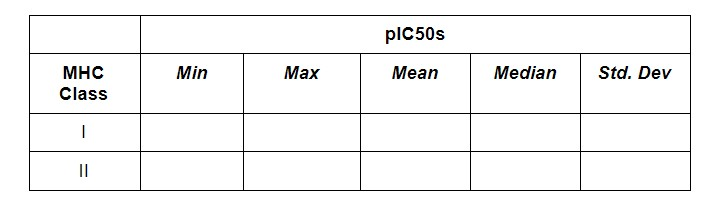

# Part 1.4

## Part 1.4: Work

In [275]:
# TODO: 1. Devise and implement an algorithm for selecting SARS-CoV-2 peptides from the set you created in part 1.3 that maximizes the ‘allele coverage’
#       (Please refer to the write-up for definitions and constraints)
#       2. Use your algorithm to compute the values required for the tables in the cell below

In [276]:
##?? I didn't make it to 9. Can I use 7?

### Algorithm Design Part 1 - Build Coverage DataFrame
Limit choices to peptides with pIC50 value greater than p_min

Create a DataFrame which lists each peptide alongside which alleles are covered by that peptide

In [277]:
def get_list_above_p_min(predictions_list,p_min):
    '''
    Returns a list of peptides which have a pIC50 value 
    above p_min.
    '''
    
    results = []
    
    for prediction in predictions_list:
        pIC50 = prediction[4]
        if pIC50 >= p_min:
            results.append(prediction)
    
    return results


def get_peptide_coverage_dict(predictions_list):
    '''
    Builds and returns a dictionary in which keys are every 
    peptide in the prediction list and the value for each 
    key is a set of alleles which are covered by that peptide.
    '''
    
    # maintain a set of peptides which cover each allele
    coverage_dict = dict()

    for allele,peptide,start,end,pIC50 in predictions_list:
        
        # define key to avoid collisions
        key = peptide + '_' + str(start) + '_' + str(end)
        
        if key in coverage_dict:
            # append allele to the list
            coverage_dict[key].add(allele)
        else:
            # add set to dictionary
            new_set = set()
            new_set.add(allele)
            coverage_dict[key] = new_set
     
    return coverage_dict


def build_row_df(coverage_dict,key,alleles):
    '''
    Builds and returns a DataFrame consisting of a single row
    with the following columns:
    
    - peptide
    - start position
    - end position
    - allele flag for each allele in alleles
    - count
    
    Allele flag is 1 if allele binds with this peptide,
    0 otherwise.
    
    Count is a sum of all allele flags for this peptide 
    '''
    
    peptide,start,end=key.split('_')

    new_dict = dict()
    new_dict['peptide']=[peptide]
    new_dict['start']=[int(start)]
    new_dict['end']=[int(end)]

    # create row for DataFrame of all alleles
    counter = 0
    for allele in alleles:

        if allele in coverage_dict[key]:
            new_dict[allele] = [1]
            counter += 1
        else:
            new_dict[allele] = [0]

    new_dict['count'] = [counter]
    return pd.DataFrame.from_dict(new_dict)
    

def build_peptide_coverage_df(coverage_dict,alleles):
    '''
    Builds and returns a DataFrame which contains a row for 
    each peptide in the coverage dictionary with columns
    for each allele in alleles.
    '''
    
    counter = 0
    df = None
    for key in coverage_dict:
        
        # build row
        df_row = build_row_df(coverage_dict,key,alleles)
        
        if counter == 0:
            df = df_row
        else:
            df = df.append(df_row)
        
        counter += 1
    return df


def get_peptide_coverage_df(predictions_list,p_min,alleles):
    '''
    Selects from the given predictions list those
    peptides which have pIC50 at or above p_min, then
    builds a DataFrame representing the allele coverage
    for each of the selected peptides.
    '''
    above = get_list_above_p_min(predictions_list,p_min)
    if len(above) > 0:
        d = get_peptide_coverage_dict(above)
        df = build_peptide_coverage_df(d, alleles)
    else:
        df = pd.DataFrame()
    return df
    

In [278]:
print('get_list_above_p_min()')
print(len(results_mhc1))
print()
print(len(get_list_above_p_min(results_mhc1,8.0)))
print(len(get_list_above_p_min(results_mhc1,7.0)))
print(len(get_list_above_p_min(results_mhc1,6.0)))
print(len(get_list_above_p_min(results_mhc1,5.0)))
print(len(get_list_above_p_min(results_mhc1,4.0)))
print(len(get_list_above_p_min(results_mhc1,3.0)))

get_list_above_p_min()
34155

0
2
3547
28936
34067
34155


In [279]:
print('test get_peptide_coverage_dict()')
above = get_list_above_p_min(results_mhc1,6.0)

d = get_peptide_coverage_dict(above)
print(len(d))
counter = 0

# print first entry in dictionary for verification
for key in d: 
    if counter < 1:
        print(key,d[key])
        print()
        allele,start,end = key.split('_')
        
        # compare with p_min list to ensure match
        for each in above:
            if each[1] == allele:
                print(each)
    counter += 1

test get_peptide_coverage_dict()
1194
CVADYSVLY_360_368 {'HLA-A*68:01', 'HLA-A*68:02', 'HLA-A*01:01', 'HLA-A*30:02', 'HLA-A*02:06'}

('HLA-A*01:01', 'CVADYSVLY', 360, 368, 6.0255923249525285)
('HLA-A*02:06', 'CVADYSVLY', 360, 368, 6.1610974683413895)
('HLA-A*30:02', 'CVADYSVLY', 360, 368, 6.26383412551894)
('HLA-A*68:01', 'CVADYSVLY', 360, 368, 6.332052706398871)
('HLA-A*68:02', 'CVADYSVLY', 360, 368, 6.006829841471768)


In [280]:
print('test build_row_df()')
row = build_row_df(d,'CVADYSVLY_360_368',class_i_list)
row.T

test build_row_df()


,0
peptide,CVADYSVLY
start,360
end,368
HLA-A*01:01,1
HLA-A*02:01,0
HLA-A*02:03,0
HLA-A*02:06,1
HLA-A*03:01,0
HLA-A*11:01,0
HLA-A*23:01,0


In [281]:
print('test build_peptide_coverage_df()')

df_coverage_test = build_peptide_coverage_df(d, class_i_list)
df_coverage_test

test build_peptide_coverage_df()


,peptide,start,end,HLA-A*01:01,HLA-A*02:01,HLA-A*02:03,HLA-A*02:06,HLA-A*03:01,HLA-A*11:01,HLA-A*23:01,...,HLA-B*15:01,HLA-B*35:01,HLA-B*40:01,HLA-B*44:02,HLA-B*44:03,HLA-B*51:01,HLA-B*53:01,HLA-B*57:01,HLA-B*58:01,count
0,CVADYSVLY,360,368,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,5
0,MFVFLVLLP,0,8,0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,3
0,SSQCVNLTT,11,19,0,1,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,6
0,QCVNLTTRT,13,21,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
0,LPPAYTNSF,23,31,0,1,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,LGQSKRVDF,1033,1041,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
0,TDAVDCALD,285,293,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
0,DDFTGCVIA,426,434,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
0,ADTTDAVRD,569,577,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1


In [282]:
print('test get_peptide_coverage_df()')

df_coverage_test = get_peptide_coverage_df(results_mhc1,8.0,class_i_list)
print(len(df_test))

df_coverage_test = get_peptide_coverage_df(results_mhc1,6.0,class_i_list)
df_coverage_test

test get_peptide_coverage_df()
1194


,peptide,start,end,HLA-A*01:01,HLA-A*02:01,HLA-A*02:03,HLA-A*02:06,HLA-A*03:01,HLA-A*11:01,HLA-A*23:01,...,HLA-B*15:01,HLA-B*35:01,HLA-B*40:01,HLA-B*44:02,HLA-B*44:03,HLA-B*51:01,HLA-B*53:01,HLA-B*57:01,HLA-B*58:01,count
0,CVADYSVLY,360,368,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,5
0,MFVFLVLLP,0,8,0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,3
0,SSQCVNLTT,11,19,0,1,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,6
0,QCVNLTTRT,13,21,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
0,LPPAYTNSF,23,31,0,1,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,LGQSKRVDF,1033,1041,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
0,TDAVDCALD,285,293,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
0,DDFTGCVIA,426,434,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
0,ADTTDAVRD,569,577,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1


In [283]:
# verify one record
for each in get_list_above_p_min(results_mhc1,6.0):
    if each[1] == 'CVADYSVLY':
        print(each)

df_coverage_test[df_coverage_test['peptide']=='CVADYSVLY'].T

('HLA-A*01:01', 'CVADYSVLY', 360, 368, 6.0255923249525285)
('HLA-A*02:06', 'CVADYSVLY', 360, 368, 6.1610974683413895)
('HLA-A*30:02', 'CVADYSVLY', 360, 368, 6.26383412551894)
('HLA-A*68:01', 'CVADYSVLY', 360, 368, 6.332052706398871)
('HLA-A*68:02', 'CVADYSVLY', 360, 368, 6.006829841471768)


,0
peptide,CVADYSVLY
start,360
end,368
HLA-A*01:01,1
HLA-A*02:01,0
HLA-A*02:03,0
HLA-A*02:06,1
HLA-A*03:01,0
HLA-A*11:01,0
HLA-A*23:01,0


### Algorithm Design Part 2 - Select Peptides for Coverage


In [284]:
# check coverage of alleles mhc 1
df_coverage_mhc1 = get_peptide_coverage_df(results_mhc1,6.0,class_i_list)
a = pd.DataFrame(df_coverage_mhc1.drop(['peptide','start','end','count'],axis=1).sum(axis=0).sort_values(),columns=['total']).reset_index()
a.rename(columns={'index':'HLA Allele'})


,HLA Allele,total
0,HLA-A*33:01,0
1,HLA-B*53:01,0
2,HLA-B*51:01,0
3,HLA-B*15:01,0
4,HLA-B*57:01,0
5,HLA-A*26:01,0
6,HLA-B*35:01,1
7,HLA-A*01:01,1
8,HLA-A*68:02,2
9,HLA-A*03:01,3


In [285]:
# check coverage of alleles mhc 2
df_coverage_mhc2 = get_peptide_coverage_df(results_mhc2,6.0,class_ii_list)
a = pd.DataFrame(df_coverage_mhc2.drop(['peptide','start','end','count'],axis=1).sum(axis=0).sort_values(),columns=['total']).reset_index()
a.rename(columns={'index':'HLA Allele'})


,HLA Allele,total
0,HLA-DPA1*0201/DPB1*1401,0
1,HLA-DRB1*1201,0
2,HLA-DRB3*0101,0
3,HLA-DRB3*0202,0
4,HLA-DRB1*0301,26
5,HLA-DQA1*0401/DQB1*0402,58
6,HLA-DQA1*0301/DQB1*0302,58
7,HLA-DPA1*0103/DPB1*0401,81
8,HLA-DQA1*0101/DQB1*0501,82
9,HLA-DQA1*0501/DQB1*0201,82


In [286]:
def get_allele_least_coverage(df_coverage,uncovered):
    '''
    Given the peptide coverage DataFrame, returns the 
    allele with the minimum number of peptides that cover it
    which has a coverage greater than zero.
    '''
    # sum the coverage for each allele column
    # then sort the values so the smallest count is at the top
    counted_and_sorted_series = df_coverage.drop(['peptide','start','end','count'],axis=1).sum(axis=0).sort_values()
    df = pd.DataFrame(counted_and_sorted_series,columns=['total']).reset_index()
    df = df.rename(columns={'index':'HLA Allele'})
    
    
    # drop all alleles with a count of zero
    df = df[df['total'] > 0]
    
    # retain only those alleles which are in uncovered
    df = df[df['HLA Allele'].isin(uncovered)]
    
    if df.shape[0] > 0:
    
        # there is an allele which can still be covered
        allele = df.iloc[0]['HLA Allele']
        total = df.iloc[0]['total']
    else:
        allele = 'NA'
        total = -1
    
    return (allele,total)


In [287]:
print('test get_allele_least_coverage()')
df_coverage_test.head().T

test get_allele_least_coverage()


,0,0,0,0,0
peptide,CVADYSVLY,MFVFLVLLP,SSQCVNLTT,QCVNLTTRT,LPPAYTNSF
start,360,0,11,13,23
end,368,8,19,21,31
HLA-A*01:01,1,0,0,0,0
HLA-A*02:01,0,1,1,1,1
HLA-A*02:03,0,1,1,1,1
HLA-A*02:06,1,1,1,0,1
HLA-A*03:01,0,0,0,0,0
HLA-A*11:01,0,0,1,0,1
HLA-A*23:01,0,0,0,0,0


In [288]:
get_allele_least_coverage(df_coverage_test.head(),['HLA-A*68:01'])

('HLA-A*68:01', 3)

In [289]:
def find_first_peptide_cover(df_coverage,allele):
    '''
    Returns a dictionary of the first peptide in the 
    DataFrame of available peptides which covers the given allele, or an 
    empty dictionary if no cover is found.
    '''
    
    # find all peptides which covers allele
    df = df_coverage[df_coverage[allele] == 1]
    
    if df.shape[0] > 0:
        
        # select the peptide with the highest coverage over all alleles
        df_peptide = df.sort_values(by=['count'],ascending=False).head(1)
        
        # return dictionary of the peptide row
        return df_peptide.to_dict()
    else:
        
        # return an empty dictionary
        return dict()
    
    
    

In [290]:
print('test find_first_peptide_cover()')

result = find_first_peptide_cover(df_coverage_test.head(),'HLA-A*02:01')
result['peptide'][0]

test find_first_peptide_cover()


'LPPAYTNSF'

In [291]:
def update_selected_peptides(peptide_dict, selected):
    '''
    Adds peptide string to selected list.
    '''
    # add to list of selected
    peptide = peptide_dict['peptide'][0]
    selected.append(peptide)
    
    
def update_uncovered_alleles(peptide_dict,uncovered,num_covered):
    '''
    Removes each allele covered by given peptide from uncovered list.
    '''
    n = num_covered
    
    for key in peptide_dict:
        
        # for each allele flag in the peptide dictionary
        if key in uncovered:
        
            # mark off the alleles covered by this peptide if they have not been covered
            flag = peptide_dict[key][0]
            if flag == 1:
                
                # peptide covers this allele
#                 print('key',key)
                uncovered.remove(key)
                n += 1
    return n

In [292]:
print('test update_selected_peptides()')

df_selected_test = df_coverage_test.head()

df_selected_test = df_selected_test[df_selected_test['peptide']=='LPPAYTNSF']
df_selected_test.T

test update_selected_peptides()


,0
peptide,LPPAYTNSF
start,23
end,31
HLA-A*01:01,0
HLA-A*02:01,1
HLA-A*02:03,1
HLA-A*02:06,1
HLA-A*03:01,0
HLA-A*11:01,1
HLA-A*23:01,0


In [293]:
# select the peptide with the highest coverage count
selected_peptide = df_selected_test.head(1)
peptide_dict = selected_peptide.to_dict()
peptide_dict['peptide'][0]

'LPPAYTNSF'

In [294]:
selected = []
update_selected_peptides(peptide_dict,selected)
selected

['LPPAYTNSF']

In [295]:
print('test update_uncovered_alleles()')
uncovered = class_i_list.copy()
num_covered = 0
print('uncovered',len(uncovered))

num_covered = update_uncovered_alleles(peptide_dict,uncovered,num_covered)
print('covered',num_covered)
print('uncovered',len(uncovered))
uncovered

test update_uncovered_alleles()
uncovered 27
covered 7
uncovered 20


['HLA-A*01:01',
 'HLA-A*03:01',
 'HLA-A*23:01',
 'HLA-A*24:02',
 'HLA-A*26:01',
 'HLA-A*30:02',
 'HLA-A*31:01',
 'HLA-A*33:01',
 'HLA-A*68:02',
 'HLA-B*07:02',
 'HLA-B*08:01',
 'HLA-B*15:01',
 'HLA-B*35:01',
 'HLA-B*40:01',
 'HLA-B*44:02',
 'HLA-B*44:03',
 'HLA-B*51:01',
 'HLA-B*53:01',
 'HLA-B*57:01',
 'HLA-B*58:01']

In [296]:
def get_nonoverlapping_peptides(peptide_dict,df):
    '''
    Removes any peptides from the given DataFrame
    if their sequence overlaps with that of the selected
    peptide, then returns a new DataFrame of the
    remaining peptides which are available.
    '''
    
    # remove any peptides from the df which overlap with the selected peptide
    start = peptide_dict['start'][0]
    end = peptide_dict['end'][0]
    removed1 = df.loc[(df['start'] >= start ) & (df['start'] <= end)]
    removed2 = df.loc[(df['end'] >= start ) & (df['end'] <= end)]
    retained = df.loc[(df['end'] < start ) | (df['start'] > end)]
    
    return (removed1,removed2,retained)
    

In [297]:
print('test get_nonoverlapping_peptides()')
print(df_coverage_test.shape)
r1,r2,retained = get_nonoverlapping_peptides(peptide_dict,df_coverage_test)
print(retained.shape)

test get_nonoverlapping_peptides()
(1194, 31)
(1178, 31)


In [298]:
r1.sort_values(by='start')

,peptide,start,end,HLA-A*01:01,HLA-A*02:01,HLA-A*02:03,HLA-A*02:06,HLA-A*03:01,HLA-A*11:01,HLA-A*23:01,...,HLA-B*15:01,HLA-B*35:01,HLA-B*40:01,HLA-B*44:02,HLA-B*44:03,HLA-B*51:01,HLA-B*53:01,HLA-B*57:01,HLA-B*58:01,count
0,LPPAYTNSF,23,31,0,1,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,7
0,PPAYTNSFT,24,32,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
0,PAYTNSFTR,25,33,0,1,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,3
0,AYTNSFTRG,26,34,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,4
0,YTNSFTRGV,27,35,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,3
0,TNSFTRGVY,28,36,0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,5
0,NSFTRGVYY,29,37,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
0,SFTRGVYYP,30,38,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
0,FTRGVYYPD,31,39,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,6


In [299]:
r2.sort_values(by='start')

,peptide,start,end,HLA-A*01:01,HLA-A*02:01,HLA-A*02:03,HLA-A*02:06,HLA-A*03:01,HLA-A*11:01,HLA-A*23:01,...,HLA-B*15:01,HLA-B*35:01,HLA-B*40:01,HLA-B*44:02,HLA-B*44:03,HLA-B*51:01,HLA-B*53:01,HLA-B*57:01,HLA-B*58:01,count
0,VNLTTRTQL,15,23,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
0,LTTRTQLPP,17,25,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
0,TTRTQLPPA,18,26,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,7
0,TRTQLPPAY,19,27,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,2
0,RTQLPPAYT,20,28,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,4
0,TQLPPAYTN,21,29,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
0,QLPPAYTNS,22,30,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
0,LPPAYTNSF,23,31,0,1,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,7


In [300]:
def select_peptides(df_coverage,alleles,design_limit):
    
    # list of selected peptides
    selected = []
    
    # list of alleles not yet covered
    uncovered = alleles.copy()
    num_covered = 0
#     print('uncovered',len(uncovered),uncovered)
    
    # select the allele with the lowest nonzero coverage
    allele,total = get_allele_least_coverage(df_coverage,uncovered)
#     print(allele, total)
    selected_peptide = find_first_peptide_cover(df_coverage,allele)
#     print(selected_peptide)

    
    # update data structures based on selection
    update_selected_peptides(selected_peptide,selected)
    num_covered = update_uncovered_alleles(selected_peptide,uncovered,num_covered)
    r1,r2,retained = get_nonoverlapping_peptides(selected_peptide,df_coverage)
#     print('selected',selected)
#     print('uncovered',len(uncovered),uncovered)
#     print(num_covered)

   
    # as long as 
    # 1 - the number of peptides selected has not exceeded the design limit
    # 2 - there are alleles which have not yet been covered
    # 3 - there are peptides left to check
    while len(selected) < design_limit and len(uncovered) != 0 and retained.shape[0] > 0:
        
        # continue searching
        allele,total = get_allele_least_coverage(retained,uncovered)
#         print()
#         print(allele,total)
        
        if total == -1:
            
            # no alleles remain which can be covered
            break
            
        else:
            
            # an allele can still be covered
#             print('uncovered',len(uncovered),uncovered)
            selected_peptide = find_first_peptide_cover(retained,allele)
#             print(selected_peptide)
        
            # update data structures based on selection
            update_selected_peptides(selected_peptide,selected)
            num_covered = update_uncovered_alleles(selected_peptide,uncovered,num_covered)
            r1,r2,retained = get_nonoverlapping_peptides(selected_peptide,retained)
#             print('selected',selected)
#             print('uncovered',len(uncovered),uncovered)
#             print(num_covered)
            
    # end while - search is over
    
    return (num_covered,selected)


In [301]:
len(class_i_list)

27

In [302]:
print('test select_peptides()')

# HLA-B*35:01 or HLA-A*01:01 have a coverage of 1 for p_min=6.0

num_covered,selected = select_peptides(df_coverage_mhc1,class_i_list,10)


test select_peptides()


In [303]:

df_coverage_mhc1[df_coverage_mhc1['peptide'].isin(selected)].T

,0,0,0,0,0,0
peptide,CVADYSVLY,SANNCTFEY,QLTPTWRVY,GAEHVNNSY,PYRVVVLSF,TQTNSPRRA
start,360,161,627,651,506,675
end,368,169,635,659,514,683
HLA-A*01:01,1,0,0,0,0,0
HLA-A*02:01,0,1,1,1,0,0
HLA-A*02:03,0,1,1,1,0,0
HLA-A*02:06,1,1,0,1,0,0
HLA-A*03:01,0,0,0,0,1,0
HLA-A*11:01,0,0,0,0,1,1
HLA-A*23:01,0,0,0,0,1,1


## Execute Algorithm on MHC I predictions
For all required design limits and p_min

In [304]:
design_limits = [10000,10,20]
p_mins = [3.0,6.0,9.0]

In [305]:
## ?? can I select if they overlap
execution_mhc1 = []
coverages_mhc1 = []
for design_limit in design_limits:
    for p_min in p_mins:
        
        df_coverage_mhc1 = get_peptide_coverage_df(results_mhc1,p_min,class_i_list)
        if df_coverage_mhc1.shape[0] > 0:
            
            # there is at least one peptide which has pIC50 >= p_min
            n,selected = select_peptides(df_coverage_mhc1,class_i_list,design_limit)
            
        else:
            
            # no peptides have pIC50 >= p_min
            n,selected = (0,[])

        execution_mhc1.append((design_limit, p_min, n, selected))
        coverages_mhc1.append(df_coverage_mhc1)

In [306]:
for execution in execution_mhc1:
    print(execution)

(10000, 3.0, 27, ['MFVFLVLLP'])
(10000, 6.0, 21, ['SANNCTFEY', 'CVADYSVLY', 'PYRVVVLSF', 'QLTPTWRVY', 'GAEHVNNSY', 'TQTNSPRRA'])
(10000, 9.0, 0, [])
(10, 3.0, 27, ['MFVFLVLLP'])
(10, 6.0, 21, ['SANNCTFEY', 'CVADYSVLY', 'PYRVVVLSF', 'QLTPTWRVY', 'GAEHVNNSY', 'TQTNSPRRA'])
(10, 9.0, 0, [])
(20, 3.0, 27, ['MFVFLVLLP'])
(20, 6.0, 21, ['SANNCTFEY', 'CVADYSVLY', 'PYRVVVLSF', 'QLTPTWRVY', 'GAEHVNNSY', 'TQTNSPRRA'])
(20, 9.0, 0, [])


## Execute Algorithm on MHC II Predictions

In [307]:
## ?? can I select if they overlap
execution_mhc2 = []
coverages_mhc2 = []
for design_limit in design_limits:
    for p_min in p_mins:
        
        df_coverage_mhc2 = get_peptide_coverage_df(results_mhc2,p_min,class_ii_list)
        if df_coverage_mhc2.shape[0] > 0:
            
            # there is at least one peptide which has pIC50 >= p_min
            n,selected = select_peptides(df_coverage_mhc2,class_ii_list,design_limit)
            
        else:
            
            # no peptides have pIC50 >= p_min
            n,selected = (0,[])

        execution_mhc2.append((design_limit, p_min, n, selected))
        coverages_mhc2.append(df_coverage_mhc2)

In [308]:
for execution in execution_mhc2:
    print(execution)

(10000, 3.0, 24, ['MFVFLVLLPLVSSQC'])
(10000, 6.0, 23, ['WRVYSTGSNVFQTRA', 'LNESLIDLQELGKYE'])
(10000, 9.0, 0, [])
(10, 3.0, 24, ['MFVFLVLLPLVSSQC'])
(10, 6.0, 23, ['WRVYSTGSNVFQTRA', 'LNESLIDLQELGKYE'])
(10, 9.0, 0, [])
(20, 3.0, 24, ['MFVFLVLLPLVSSQC'])
(20, 6.0, 23, ['WRVYSTGSNVFQTRA', 'LNESLIDLQELGKYE'])
(20, 9.0, 0, [])


In [309]:
# check if results make sense

mhc2_execution_r1 = coverages_mhc2[0]

mhc2_execution_r1[mhc2_execution_r1['peptide'].isin(['MFVFLVLLPLVSSQC'])].T


,0
peptide,MFVFLVLLPLVSSQC
start,0
end,14
HLA-DRB1*0101,1
HLA-DRB1*0301,1
HLA-DRB1*0401,1
HLA-DRB1*0405,1
HLA-DRB1*0701,1
HLA-DRB1*0802,1
HLA-DRB1*0901,1


In [310]:
mhc2_execution_r2 = coverages_mhc2[1]

mhc2_execution_r2[mhc2_execution_r2['peptide'].isin(['WRVYSTGSNVFQTRA', 'LNESLIDLQELGKYE'])].T

,0,0
peptide,WRVYSTGSNVFQTRA,LNESLIDLQELGKYE
start,632,1192
end,646,1206
HLA-DRB1*0101,1,1
HLA-DRB1*0301,1,0
HLA-DRB1*0401,1,1
HLA-DRB1*0405,1,1
HLA-DRB1*0701,1,1
HLA-DRB1*0802,1,0
HLA-DRB1*0901,1,1


## Format MHC 1 Results into table

In [311]:
results_formatted_mhc1 = []
for design_limit, p_min, n, selected in execution_mhc1:
    coverage = float(n) / len(class_i_list)
    new_result = [design_limit,p_min,len(selected),coverage]
    results_formatted_mhc1.append(new_result)

col_list = ['Design Limit','p_min','Actual Design Size','Coverage']
pd.DataFrame(results_formatted_mhc1,columns=col_list)

,Design Limit,p_min,Actual Design Size,Coverage
0,10000,3.0,1,1.000000
1,10000,6.0,6,0.777778
2,10000,9.0,0,0.000000
3,10,3.0,1,1.000000
4,10,6.0,6,0.777778
5,10,9.0,0,0.000000
6,20,3.0,1,1.000000
7,20,6.0,6,0.777778
8,20,9.0,0,0.000000


## Format MHC 2 Results into table

In [312]:
results_formatted_mhc2 = []
for design_limit, p_min, n, selected in execution_mhc2:
    coverage = float(n) / len(class_ii_list)
    new_result = [design_limit,p_min,len(selected),coverage]
    results_formatted_mhc2.append(new_result)

col_list = ['Design Limit','p_min','Actual Design Size','Coverage']
pd.DataFrame(results_formatted_mhc2,columns=col_list)

,Design Limit,p_min,Actual Design Size,Coverage
0,10000,3.0,1,0.888889
1,10000,6.0,2,0.851852
2,10000,9.0,0,0.000000
3,10,3.0,1,0.888889
4,10,6.0,2,0.851852
5,10,9.0,0,0.000000
6,20,3.0,1,0.888889
7,20,6.0,2,0.851852
8,20,9.0,0,0.000000


## Part 1.4: Answer

Briefly describe the algorithm you devised: **YOUR EXPLANATION HERE**

If you would like to manually fill in the tables provided in the write-up, please replace the empty tables below with a screenshot of your filled in table. Alternatively, you could display the tables as the output of above cells as long as they contain all of the relevant information.

**MHC I Alleles**

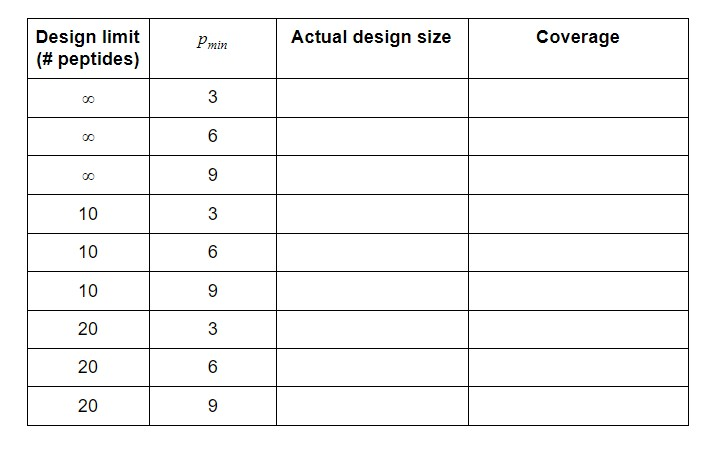

**MHC II Alleles**

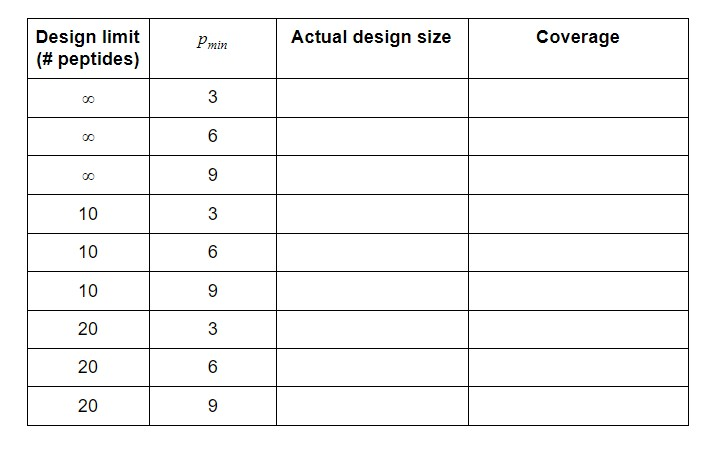


# Part 1.5

## Part 1.5: Work

In [ ]:
'''
TODO: 1. Determine criteria for selecting 20 peptides for your vaccine
        (You do not need to have an equal number of peptides ‘covering’ MHC I and MHC II alleles)
      2. Apply this criteria to obtain the required information for table in the cell below.      
'''

## Part 1.5: Answer

Explain the criteria you used to select peptides: **YOUR EXPLANATION HERE**

What is the expected coverage of your design? **YOUR ANSWER HERE**

If you would like to manually fill in the table provided in the write-up, please replace the empty table below with a screenshot of your filled in table. Alternatively, you could display the table as the output of above cell as long as it contains all of the relevant information.

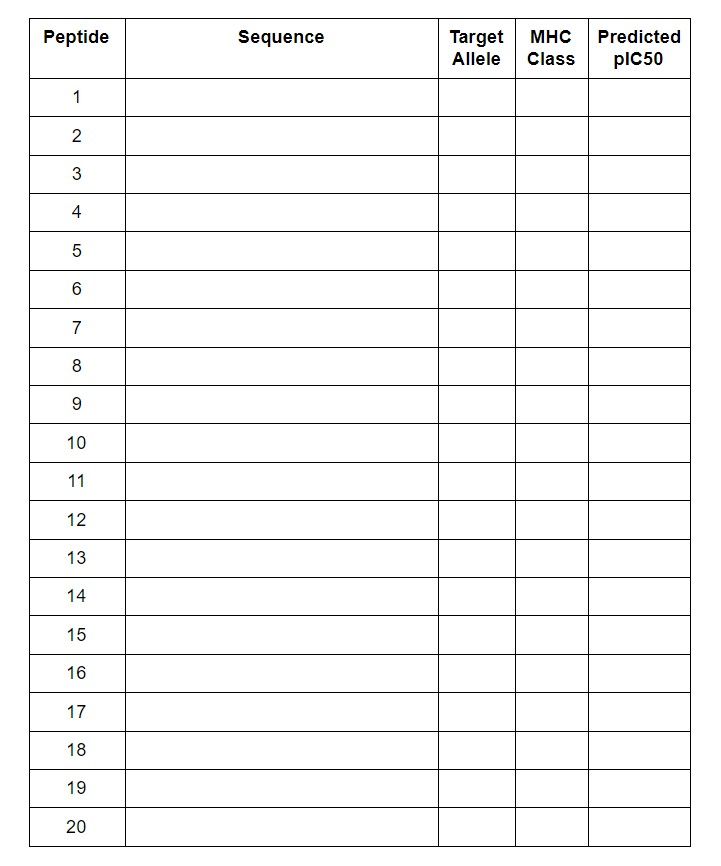